### Introduction
Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

- **Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}
- **Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight
- **Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

In this tutorial, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python 2.7

### Theoretical Overview
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

![LDA_Model](https://github.com/chdoig/pytexas2015-topic-modeling/blob/master/images/lda-4.png?raw=true)

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

- `psi`, the distribution of words for each topic K
- `phi`, the distribution of topics for each document i

#### Parameters of LDA

- `Alpha parameter` is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- `Beta parameter` is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

### LDA Implementation

1. Loading data
2. Data cleaning
3. Exploratory analysis
4. Preparing data for LDA analysis
5. Model Evaluation and parameter tuning

#### Loading data

For this tutorial, we’ll use the dataset of papers published in NIPS conference. The NIPS conference (Neural Information Processing Systems) is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

<img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_158/img/nips_logo.png" alt="The logo of NIPS (Neural Information Processing Systems)">

Let’s start by looking at the content of the file

In [21]:
# Importing modules
import pandas as pd
# import os

# os.chdir('..')

# Read data into papers
papers = pd.read_csv('Covid_19_tweets_train.csv',encoding='latin1')

# Print head
papers.head()

C:\Users\Vision\.conda\envs\Tensor\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


#### Data Cleaning

Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

In [3]:
# Remove the columns
papers = papers.drop(columns=['UserName', 'ScreenName', 'Location','TweetAt'], axis=1)

# Print out the first rows of papers
papers.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


#### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [4]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = papers['OriginalTweet'].map(lambda x: re.sub(r'[,\.!?]|(http\S+)|@\S+', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

0                                            and  and 
1    advice talk to your neighbours family to excha...
2    coronavirus australia: woolworths to give elde...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the #covi...
Name: paper_text_processed, dtype: object

#### Exploratory Analysis

To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

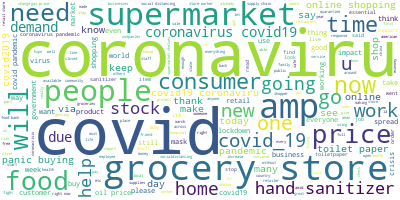

In [5]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

#### Prepare text for LDA analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.

We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.

C:\Users\Vision\.conda\envs\Tensor\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


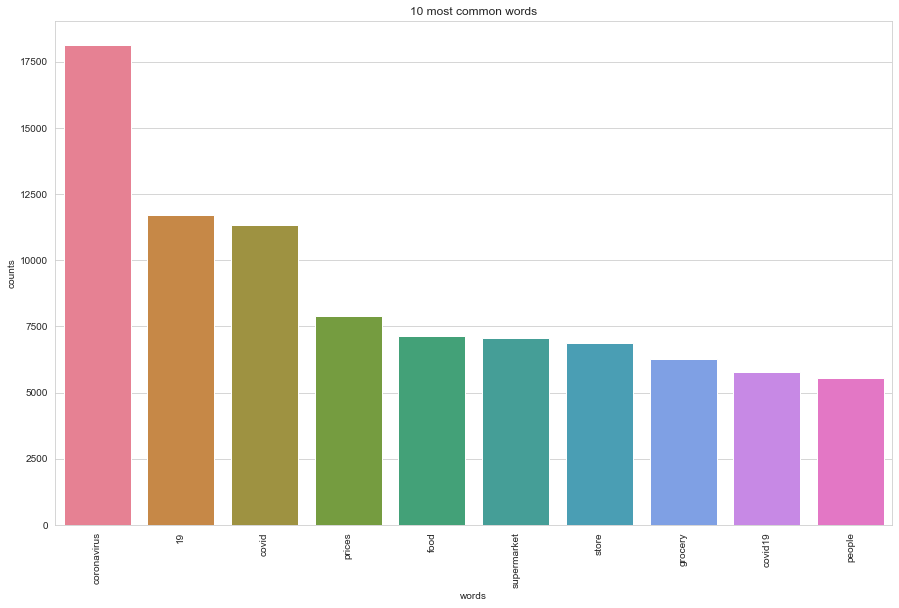

In [6]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['paper_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### LDA model tranining

To keep things simple, we will only tweak the number of topic parameters.

In [24]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
food supermarket 19 people covid panic need stock workers coronavirus

Topic #1:
coronavirus store supermarket grocery covid19 people covid_19 just toiletpaper sanitizer

Topic #2:
coronavirus 19 covid store grocery workers consumer amp covid19 sanitizer

Topic #3:
prices 19 covid coronavirus consumer oil amp pandemic demand impact

Topic #4:
19 covid coronavirus online shopping prices covid19 pandemic food demand


### Analyzing our LDA model

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.
For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [25]:
%%time
import os
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
# if 1 == 1:

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)
        
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath) as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

Wall time: 1min 22s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.185740 -0.108961       1        1  29.089090
4      0.061964  0.018679       2        1  18.611764
3      0.200664 -0.080604       3        1  18.219871
0     -0.098201  0.074162       4        1  17.628018
2      0.021312  0.096723       5        1  16.451257, topic_info=              Term         Freq        Total Category  logprob  loglift
34083       prices  7360.000000  7360.000000  Default  30.0000  30.0000
17729         food  6776.000000  6776.000000  Default  29.0000  29.0000
42142  supermarket  6615.000000  6615.000000  Default  28.0000  28.0000
31082       online  3167.000000  3167.000000  Default  27.0000  27.0000
41565        store  6385.000000  6385.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
17729         food   514.934799  6776.668195   Topic5  -5.4034  -0.7724
34083       prices   517.794074  7360.774764   Topic5  -5.3979  -0.8496
31465     outbreak   309.459223  1056.591636   Topic5  -5.9126   0.5768
29620         need   321.898730  2556.080262   Topic5  -5.8732  -0.2672
7464      business   287.461879   942.965899   Topic5  -5.9864   0.6168

[420 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
581        1  0.087118    19
581        2  0.295234    19
581        3  0.263272    19
581        4  0.177433    19
581        5  0.176976    19
...      ...       ...   ...
48437      1  0.279313  year
48437      2  0.098349  year
48437      3  0.584196  year
48437      4  0.035406  year
48437      5  0.001967  year

[860 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 1, 3])

In [26]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.185740 -0.108961       1        1  29.089090
4      0.061964  0.018679       2        1  18.611764
3      0.200664 -0.080604       3        1  18.219871
0     -0.098201  0.074162       4        1  17.628018
2      0.021312  0.096723       5        1  16.451257, topic_info=              Term         Freq        Total Category  logprob  loglift
34083       prices  7360.000000  7360.000000  Default  30.0000  30.0000
17729         food  6776.000000  6776.000000  Default  29.0000  29.0000
42142  supermarket  6615.000000  6615.000000  Default  28.0000  28.0000
31082       online  3167.000000  3167.000000  Default  27.0000  27.0000
41565        store  6385.000000  6385.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
17729         food   514.934799  6776.668195   Topic5  -5.4034  -0.7724
34083       prices   517.794074  7360.774764   Topic5  -5.3979  -0.8496
31465     outbreak   309.459223  1056.591636   Topic5  -5.9126   0.5768
29620         need   321.898730  2556.080262   Topic5  -5.8732  -0.2672
7464      business   287.461879   942.965899   Topic5  -5.9864   0.6168

[420 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
581        1  0.087118    19
581        2  0.295234    19
581        3  0.263272    19
581        4  0.177433    19
581        5  0.176976    19
...      ...       ...   ...
48437      1  0.279313  year
48437      2  0.098349  year
48437      3  0.584196  year
48437      4  0.035406  year
48437      5  0.001967  year

[860 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 1, 3])

### Closing Notes
Machine learning has become increasingly popular over the past decade, and recent advances in computational availability have led to exponential growth to people looking for ways how new methods can be incorporated to advance the field of Natural Language Processing.

Often, we treat topic models as black-box algorithms, but hopefully, this post addressed to shed light on the underlying math, and intuitions behind it, and high-level code to get you started with any textual data.

In the next article, we’ll go one step deeper into understanding how you can evaluate the performance of topic models, tune its hyper-parameters to get more intuitive and reliable results.

** **
#### Sources:
1. Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
2. Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
3. Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
4. A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf
